# Car Price Prediction

In [162]:
import kagglehub
import os
import pandas as pd
import numpy as np
import pickle
import joblib
import seaborn as sns
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

### Downloading dataset from Kaggle

In [113]:
# kagglehub.login()
dataset_path = kagglehub.dataset_download('nehalbirla/vehicle-dataset-from-cardekho')

### Import dataset from local downloads

In [114]:
csv_file_path = os.path.join(dataset_path, "car details v4.csv")
df = pd.read_csv(csv_file_path)

### Data Cleaning

In [115]:
df.shape

(2059, 20)

In [116]:
df.columns

Index(['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine',
       'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity'],
      dtype='object')

In [117]:
df.isnull().sum()

# Some null values - but ~10% NA only so dont need to remove. Can do fillna()

Make                    0
Model                   0
Price                   0
Year                    0
Kilometer               0
Fuel Type               0
Transmission            0
Location                0
Color                   0
Owner                   0
Seller Type             0
Engine                 80
Max Power              80
Max Torque             80
Drivetrain            136
Length                 64
Width                  64
Height                 64
Seating Capacity       64
Fuel Tank Capacity    113
dtype: int64

In [118]:
df.dtypes

Make                   object
Model                  object
Price                   int64
Year                    int64
Kilometer               int64
Fuel Type              object
Transmission           object
Location               object
Color                  object
Owner                  object
Seller Type            object
Engine                 object
Max Power              object
Max Torque             object
Drivetrain             object
Length                float64
Width                 float64
Height                float64
Seating Capacity      float64
Fuel Tank Capacity    float64
dtype: object

In [119]:
# Engine - convert to numeric

df['Engine']  = df['Engine'].str.replace(' cc', '')
df['Engine'] = pd.to_numeric(df['Engine'])

count    1979.000000
mean     1692.575543
std       643.736294
min       624.000000
25%      1197.000000
50%      1498.000000
75%      1995.000000
max      6592.000000
Name: Engine, dtype: float64


<Axes: >

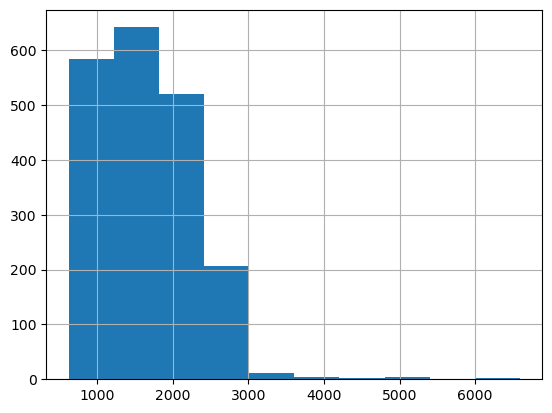

In [120]:
print(df['Engine'].describe())
df['Engine'].hist()
#graph is skewed to the right - extreme outliers (max val) - so median filling used not mean

0


<Axes: >

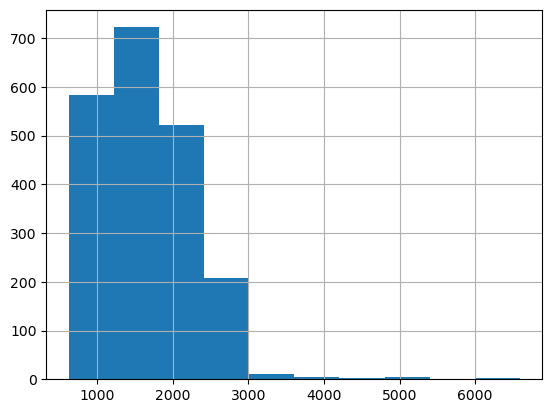

In [121]:
# Filling missing Engine values with the median
df['Engine'] = df['Engine'].fillna(df['Engine'].median())
print(df['Engine'].isnull().sum())
df['Engine'].hist()

In [122]:
# Repeat similar steps for other cols

# Clean 'Max Power' column (extract number)
df['Max Power (bhp)'] = df['Max Power'].str.extract(r'(\d*)').astype(float)

# Clean 'Max Torque' column (extract number)
df['Max Torque (Nm)'] = df['Max Torque'].str.extract(r'(\d*)').astype(float)


count    1979.000000
mean      129.611420
std        65.074136
min        35.000000
25%        83.000000
50%       116.000000
75%       171.000000
max       660.000000
Name: Max Power (bhp), dtype: float64


<Axes: >

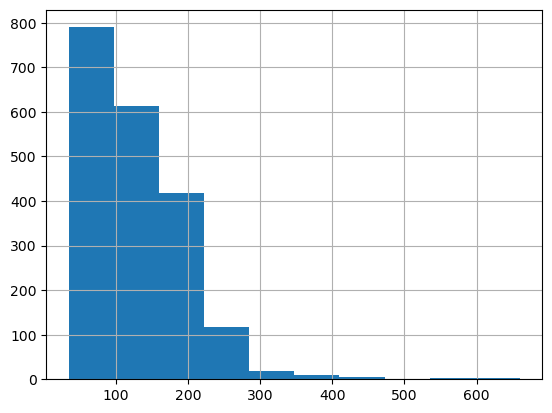

In [123]:
print(df['Max Power (bhp)'].describe())
df['Max Power (bhp)'].hist()

count    1979.000000
mean      245.841334
std       140.473819
min        48.000000
25%       115.000000
50%       200.000000
75%       350.000000
max       780.000000
Name: Max Torque (Nm), dtype: float64


<Axes: >

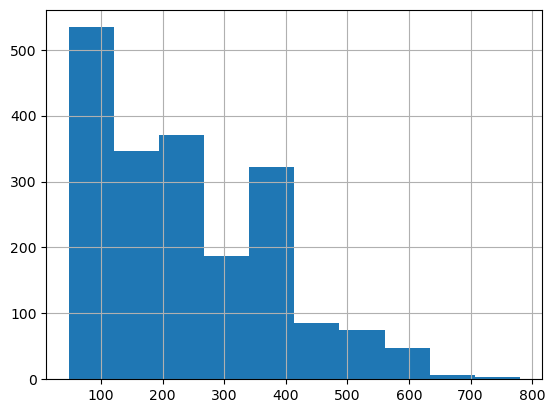

In [124]:
print(df['Max Torque (Nm)'].describe())
df['Max Torque (Nm)'].hist()


In [125]:
df['Max Power (bhp)'] = df['Max Power (bhp)'].fillna(df['Max Power (bhp)'].median())
print(df['Max Power (bhp)'].isnull().sum())

df['Max Torque (Nm)'] = df['Max Torque (Nm)'].fillna(df['Max Torque (Nm)'].median())
print(df['Max Torque (Nm)'].isnull().sum())

0
0


In [126]:
df.isnull().sum()

Make                    0
Model                   0
Price                   0
Year                    0
Kilometer               0
Fuel Type               0
Transmission            0
Location                0
Color                   0
Owner                   0
Seller Type             0
Engine                  0
Max Power              80
Max Torque             80
Drivetrain            136
Length                 64
Width                  64
Height                 64
Seating Capacity       64
Fuel Tank Capacity    113
Max Power (bhp)         0
Max Torque (Nm)         0
dtype: int64

count    1995.000000
mean     4280.860652
std       442.458507
min      3099.000000
25%      3985.000000
50%      4370.000000
75%      4629.000000
max      5569.000000
Name: Length, dtype: float64


<Axes: >

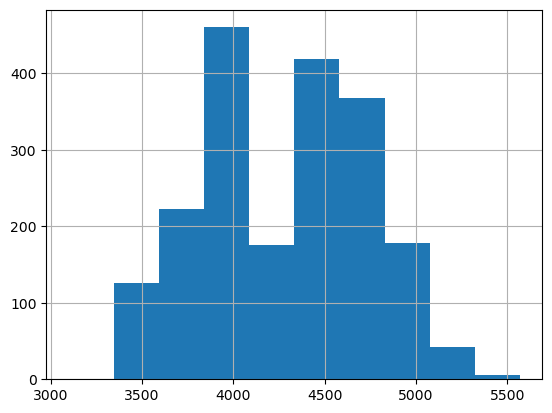

In [127]:
print(df['Length'].describe())
df['Length'].hist()

count    1995.000000
mean     1767.991980
std       135.265825
min      1475.000000
25%      1695.000000
50%      1770.000000
75%      1831.500000
max      2220.000000
Name: Width, dtype: float64


<Axes: >

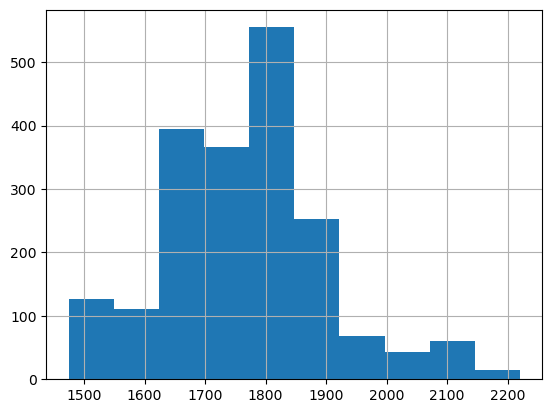

In [128]:
print(df['Width'].describe())
df['Width'].hist()


count    1995.000000
mean     1591.735338
std       136.073956
min      1165.000000
25%      1485.000000
50%      1545.000000
75%      1675.000000
max      1995.000000
Name: Height, dtype: float64


<Axes: >

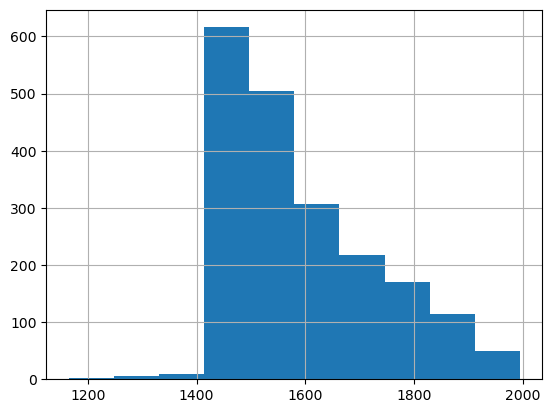

In [129]:
print(df['Height'].describe())
df['Height'].hist()


count    1946.000000
mean       52.002210
std        15.110198
min        15.000000
25%        41.250000
50%        50.000000
75%        60.000000
max       105.000000
Name: Fuel Tank Capacity, dtype: float64


<Axes: >

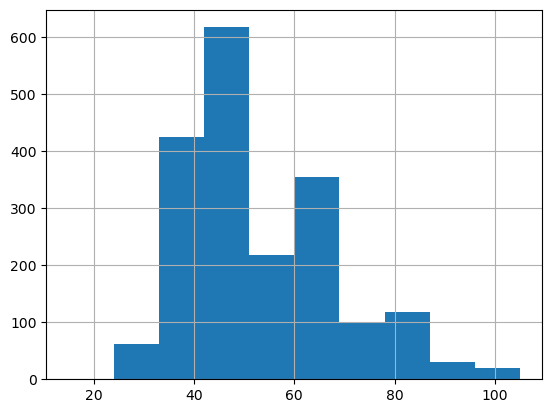

In [130]:
print(df['Fuel Tank Capacity'].describe())
df['Fuel Tank Capacity'].hist()

In [131]:
df['Length'] = df['Length'].fillna(df['Length'].mean())
df['Width'] = df['Width'].fillna(df['Width'].mean())
df['Height'] = df['Height'].fillna(df['Height'].median()) #right skewed
df['Fuel Tank Capacity'] = df['Fuel Tank Capacity'].fillna(df['Fuel Tank Capacity'].median()) #right skewed


In [132]:
df['Year'] = 2025-df['Year'] #number of years instead of raw year

In [133]:
#categorical values  

df['Seating Capacity'] = df['Seating Capacity'].fillna(df['Seating Capacity'].mode()[0])
df['Drivetrain'] = df['Drivetrain'].fillna(df['Drivetrain'].mode()[0])
#delete redundant cols
df = df.drop(['Location','Length','Width','Height','Max Power','Max Torque'],axis=1)

In [134]:
df.isnull().sum() #NA values replaced

Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Color                 0
Owner                 0
Seller Type           0
Engine                0
Drivetrain            0
Seating Capacity      0
Fuel Tank Capacity    0
Max Power (bhp)       0
Max Torque (Nm)       0
dtype: int64

In [135]:
df.dtypes


Make                   object
Model                  object
Price                   int64
Year                    int64
Kilometer               int64
Fuel Type              object
Transmission           object
Color                  object
Owner                  object
Seller Type            object
Engine                float64
Drivetrain             object
Seating Capacity      float64
Fuel Tank Capacity    float64
Max Power (bhp)       float64
Max Torque (Nm)       float64
dtype: object

In [136]:
for col in df:
    if type(df[col][0])==str:
        print(col+" : "+str(len(df[col].unique())))

Make : 33
Model : 1050
Fuel Type : 9
Transmission : 2
Color : 17
Owner : 6
Seller Type : 3
Drivetrain : 3


### Encoding categorical values

In [161]:
#encoding for categorical values

# Ordinal: Owner
# Nominal: Make (many), Model (many), Fuel Type, Transmission, Color (many), Seller Type, Drivetrain


# Hash encoding: n_components = number of output columns

cols_to_hash = ['Make', 'Model', 'Color']
hash_encoder = ce.HashingEncoder(cols=cols_to_hash), n_components=8)
df_hash = hash_encoder.fit_transform(df[cols_to_hash])

# -------------------- 2. One-hot Encoding for manageable categoricals --------------------
df_onehot = pd.get_dummies(df, columns=[
    'Fuel Type',
    'Transmission',
    'Seller Type',
    'Drivetrain'
], drop_first=True)

# -------------------- 3. Label Encoding for ordinal --------------------
le = LabelEncoder()
df_onehot['Owner'] = le.fit_transform(df_onehot['Owner'])

# -------------------- 4. Final Feature Assembly --------------------
# Drop original hash columns and merge
df_final = pd.concat([
    df_onehot.drop(columns=cols_to_hash),  # drop original hash-encoded columns
    df_hash  # add hashed columns
], axis=1)



df_final


,Price,Year,Kilometer,Owner,Engine,Seating Capacity,Fuel Tank Capacity,Max Power (bhp),Max Torque (Nm),Fuel Type_CNG + CNG,...,Drivetrain_FWD,Drivetrain_RWD,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,505000,8,87150,1,1198.0,5.0,35.0,87.0,109.0,False,...,True,False,0,0,1,0,0,0,1,1
1,450000,11,75000,3,1248.0,5.0,42.0,74.0,190.0,False,...,True,False,0,0,1,0,1,0,1,0
2,220000,14,67000,1,1197.0,5.0,35.0,79.0,112.0,False,...,True,False,0,0,1,1,0,0,1,0
3,799000,6,37500,1,1197.0,5.0,37.0,82.0,113.0,False,...,True,False,0,1,0,0,1,0,0,1
4,1950000,7,69000,1,2393.0,7.0,55.0,148.0,343.0,False,...,False,True,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,850000,9,90300,1,2179.0,7.0,70.0,138.0,330.0,False,...,True,False,1,0,0,0,0,0,1,1
2055,275000,11,83000,3,814.0,5.0,32.0,55.0,75.0,False,...,True,False,0,1,0,0,0,0,2,0
2056,240000,12,73000,1,1196.0,5.0,45.0,70.0,102.0,False,...,True,False,1,0,0,2,0,0,0,0
2057,4290000,7,60474,1,1995.0,5.0,65.0,188.0,400.0,False,...,False,True,2,0,0,0,0,0,1,0


In [163]:
# Save the encoder properly
joblib.dump(hash_encoder, 'hash_encoder.pkl')

['hash_encoder.pkl']

### Preparation for ML

count    2.059000e+03
mean     1.702992e+06
std      2.419881e+06
min      4.900000e+04
25%      4.849990e+05
50%      8.250000e+05
75%      1.925000e+06
max      3.500000e+07
Name: Price, dtype: float64


<Axes: >

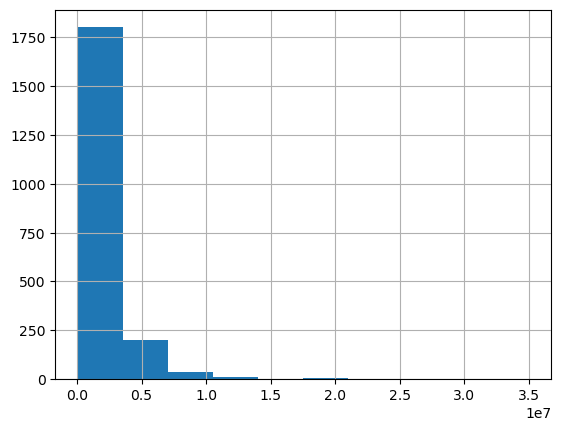

In [139]:
print(df_final['Price'].describe())
df_final['Price'].hist()  #Right skewed - might need log transform

In [140]:
y = np.log1p(df_final['Price']) #log transform Price (performs better) - since Price has very high values also
X = df_final.drop('Price', axis=1)

In [141]:
X.shape, y.shape

((2059, 29), (2059,))

In [142]:
## Feature selection

selector = SelectKBest(score_func=f_regression,  k='all')

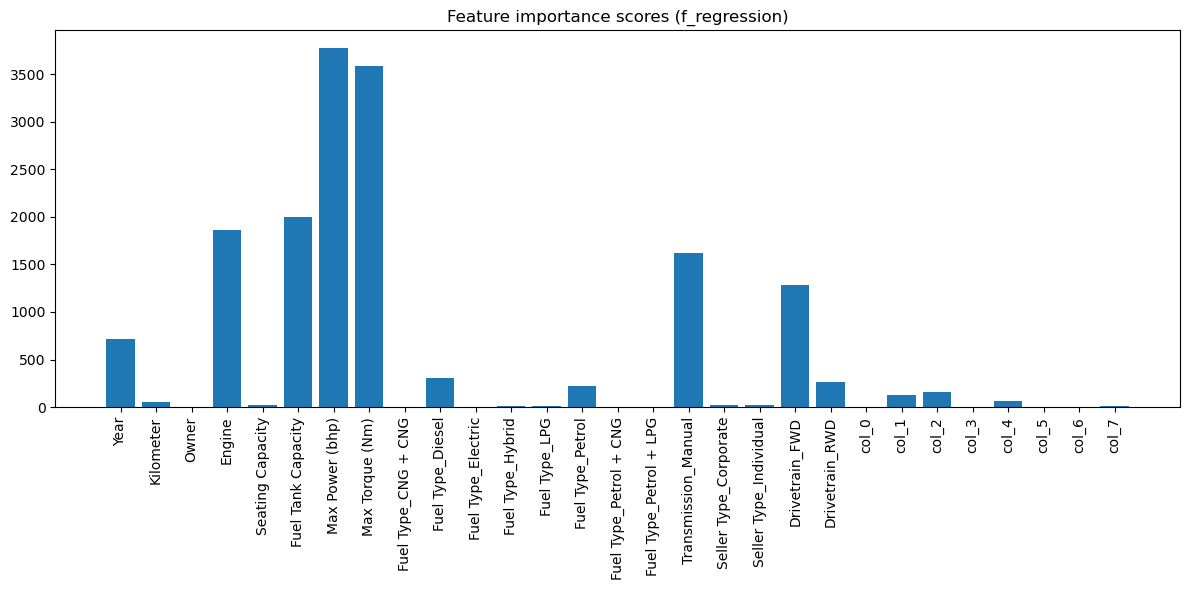

In [143]:
# Try all features, plot scores

scores = selector.fit(X, y).scores_
plt.figure(figsize=(12,6))
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(scores)), X.columns, rotation=90)
plt.title("Feature importance scores (f_regression)")
plt.tight_layout()
plt.show()


In [160]:
selector = SelectKBest(score_func=f_regression,  k=7) # k = 7 based on plot
X_selected = selector.fit_transform(X, y)


selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
print(selected_features)


Index(['Year', 'Engine', 'Fuel Tank Capacity', 'Max Power (bhp)',
       'Max Torque (Nm)', 'Transmission_Manual', 'Drivetrain_FWD'],
      dtype='object')


In [146]:
X = df_final[selected_features]

In [147]:
X.shape,y.shape

((2059, 10), (2059,))

In [148]:
# Train-test split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### Linear Regression

In [149]:
lin_model=LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

In [150]:
Train_pred_linear = lin_model.predict(X_train)
linear_train_accuracy_score=metrics.r2_score(y_train,Train_pred_linear)
print("Train R2_score :",linear_train_accuracy_score)

test_pred_linear=lin_model.predict(X_test)
linear_test_accuracy_score = metrics.r2_score(y_test,test_pred_linear)
print("Test R2_score :",linear_test_accuracy_score)


mse_linear = metrics.mean_squared_error(y_test, test_pred_linear)
print(f'Mean Squared Error: {mse_linear}')

Train R2_score : 0.8885358200706254
Test R2_score : 0.8960404601153317
Mean Squared Error: 0.09797934131274523


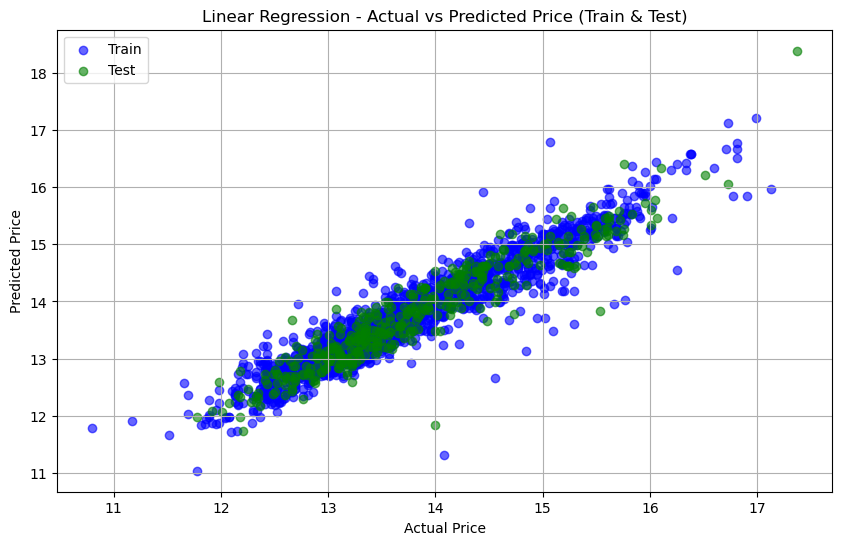

In [151]:
# Visualise

plt.figure(figsize=(10, 6))

# Plot for Training data
plt.scatter(y_train, Train_pred_linear, color='blue', label='Train', alpha=0.6)

# Plot for Testing data
plt.scatter(y_test, test_pred_linear, color='green', label='Test', alpha=0.6)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression - Actual vs Predicted Price (Train & Test)")
plt.legend()
plt.grid(True)
plt.show()

### Lasso Regression

In [152]:
lasso_model=Lasso()
lasso_model.fit(X_train,y_train)

Lasso()

In [153]:
train_data_pred=lasso_model.predict(X_train)
lasso_train_accuracy_score=metrics.r2_score(y_train,train_data_pred)
print("Train R2 Scored : ",lasso_train_accuracy_score)

test_pred_lasso=lasso_model.predict(X_test)
lasso_test_accuracy_score=metrics.r2_score(y_test,test_pred_lasso)
print("Test R2 Scored : ",lasso_test_accuracy_score)

mse_lasso = metrics.mean_squared_error(y_test, test_pred_lasso)
print(f'Mean Squared Error: {mse_lasso}')



Train R2 Scored :  0.7573484085184411
Test R2 Scored :  0.7890491502737407
Mean Squared Error: 0.19881605217253334


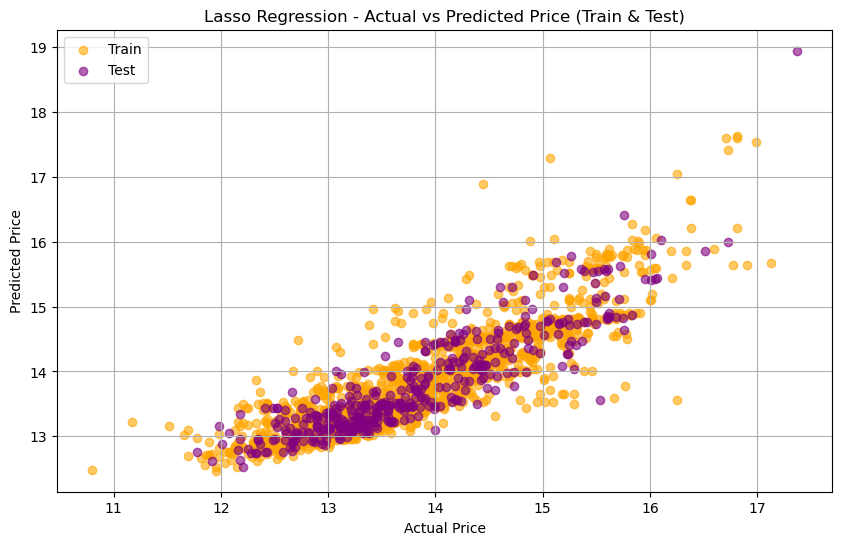

In [154]:
plt.figure(figsize=(10, 6))

# Training data: Lasso predictions
plt.scatter(y_train, train_data_pred, color='orange', label='Train', alpha=0.6)

# Test data: Lasso predictions
plt.scatter(y_test, test_pred_lasso, color='purple', label='Test', alpha=0.6)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Lasso Regression - Actual vs Predicted Price (Train & Test)")
plt.legend()
plt.grid(True)
plt.show()

### Random Forest

In [155]:
regressor = RandomForestRegressor(n_estimators=5, random_state=0)

regressor.fit(X_train,y_train)

RandomForestRegressor(n_estimators=5, random_state=0)

In [156]:


train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)


mse_rf = metrics.mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error: {mse_rf}')

rf_train_accuracy_score = metrics.r2_score(y_train, train_predictions)
print(f'Train R-squared: {rf_train_accuracy_score}')

rf_test_accuracy_score = metrics.r2_score(y_test, test_predictions)
print(f'Test R-squared: {rf_test_accuracy_score}')

Mean Squared Error: 0.06588653951484127
Train R-squared: 0.9766185193750615
Test R-squared: 0.9300920557253743


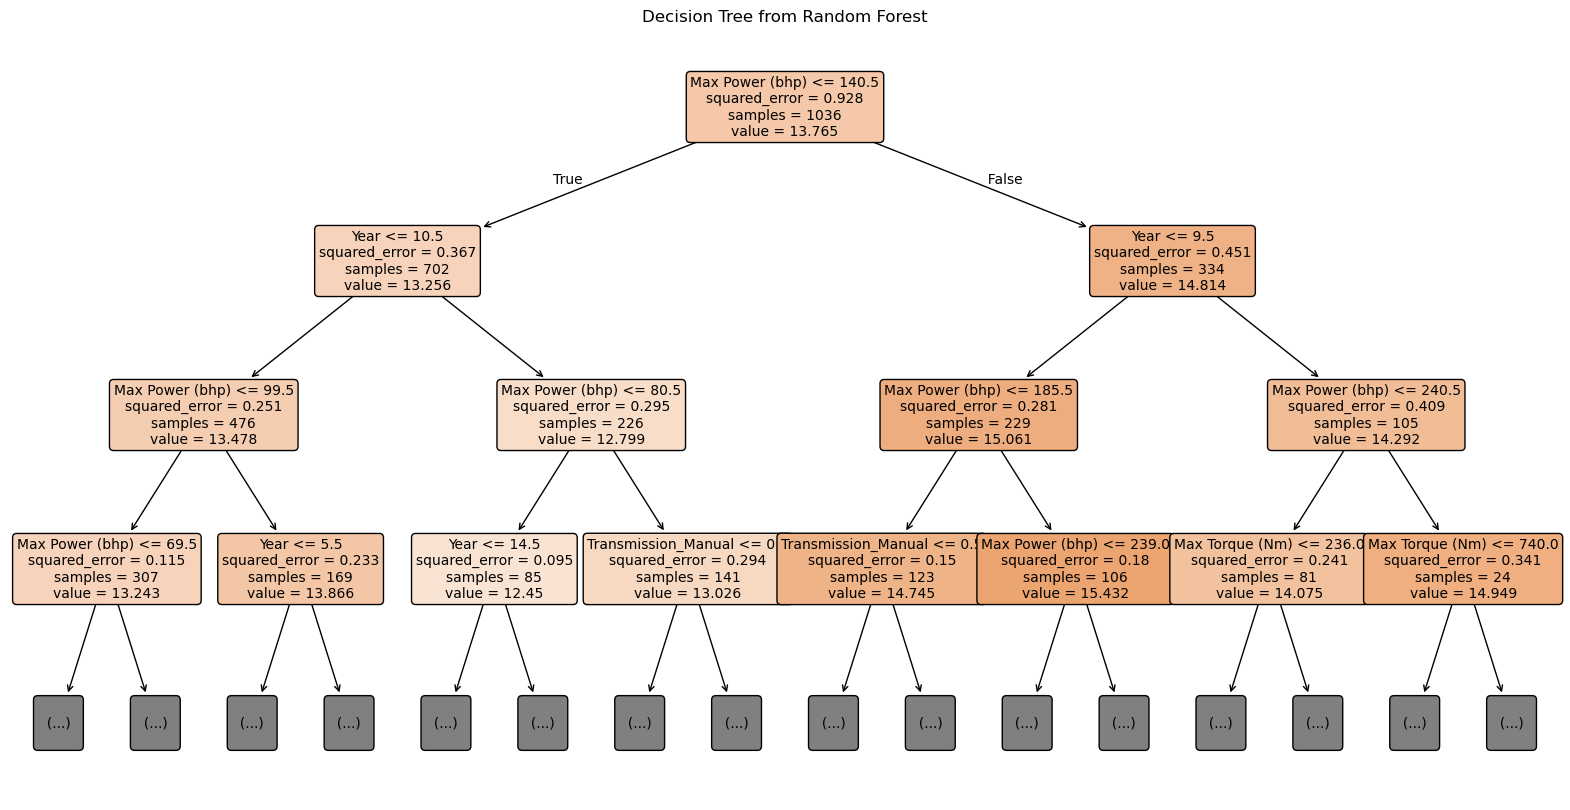

In [157]:

# Plot the first tree in the forest (index 0)
plt.figure(figsize=(20, 10))
plot_tree(regressor.estimators_[0], 
          feature_names=X_train.columns, 
          filled=True, 
          rounded=True, 
          max_depth=3,  # Limit tree depth for readability
          fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()


### Accuracy and Error plots for different models

In [158]:
r2_scores = {
    "Linear (Train)": linear_train_accuracy_score,
    "Linear (Test)": linear_test_accuracy_score,
    "Lasso (Train)": lasso_train_accuracy_score,
    "Lasso (Test)": lasso_test_accuracy_score,
    "Random Forest (Train)": rf_train_accuracy_score,
    "Random Forest (Test)": rf_test_accuracy_score
}

mse_scores = {
    "Linear": mse_linear,
    "Lasso": mse_lasso,
    "Random Forest": mse_rf
}

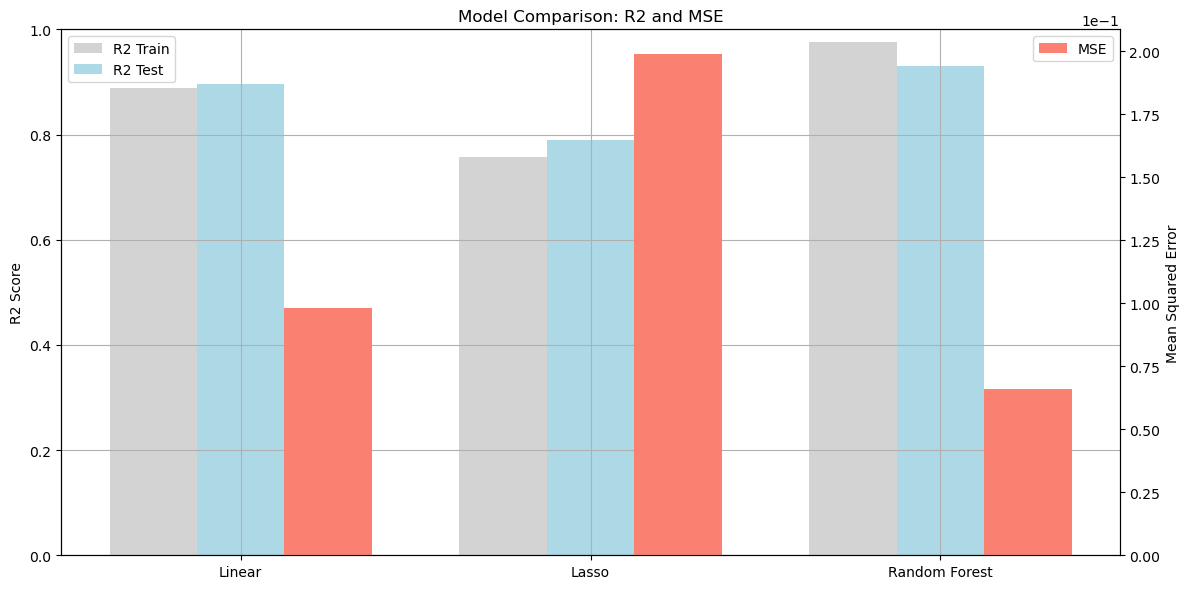

In [159]:
models = ["Linear", "Lasso", "Random Forest"]
train_r2 = [r2_scores.get(f"{model} (Train)", 0) for model in models]
test_r2 = [r2_scores.get(f"{model} (Test)", 0) for model in models]
mse_vals = [mse_scores.get(model, 0) for model in models]

x = np.arange(len(models))
width = 0.25

# --- Step 3: Plot ---

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot R² bars on primary y-axis
bar1 = ax1.bar(x - width, train_r2, width, label='R2 Train', color='lightgrey')
bar2 = ax1.bar(x, test_r2, width, label='R2 Test', color='lightblue')
ax1.set_ylabel('R2 Score')
ax1.set_ylim(0, 1)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title("Model Comparison: R2 and MSE")
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot MSE bars on secondary y-axis
ax2 = ax1.twinx()
bar3 = ax2.bar(x + width, mse_vals, width, label='MSE', color='salmon')
ax2.set_ylabel('Mean Squared Error')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [110]:
#Best model = RF model (High R2 and Low MSE)

import pickle
# open a file, where you ant to store the data
file = open('random_forest_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(regressor, file)

In [111]:
df.describe()

,Price,Year,Kilometer,Owner,Engine,Seating Capacity,Fuel Tank Capacity,Max Power (bhp),Max Torque (Nm),col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
count,2.059000e+03,2059.000000,2.059000e+03,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000
mean,1.702992e+06,8.574551,5.422471e+04,1.465274,1685.015542,5.296746,51.892326,129.082564,244.060223,0.380767,0.382224,0.485673,0.149102,0.286547,0.160272,0.796503,0.358912
std,2.419881e+06,3.363564,5.736172e+04,0.925890,632.220086,0.811029,14.696588,63.851025,138.001223,0.575444,0.579949,0.588325,0.370974,0.504083,0.381235,0.731671,0.549655
min,4.900000e+04,3.000000,0.000000e+00,0.000000,624.000000,2.000000,15.000000,35.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.849990e+05,6.000000,2.900000e+04,1.000000,1198.000000,5.000000,42.000000,83.000000,115.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.250000e+05,8.000000,5.000000e+04,1.000000,1498.000000,5.000000,50.000000,116.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.925000e+06,11.000000,7.200000e+04,1.000000,1995.000000,5.000000,60.000000,169.000000,343.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,3.500000e+07,37.000000,2.000000e+06,5.000000,6592.000000,8.000000,105.000000,660.000000,780.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000
